In [52]:
from pettingzoo.classic import connect_four_v3
import random
import numpy as np
from tqdm import tqdm
import time
import matplotlib.pyplot as plt

# Set up agent

In [53]:
class Player:
    def __init__(self, get_action) -> None:
        self.get_action = get_action

# Set up training

In [169]:
class Qlearning:
    def __init__(self, exploration_factor=0.5, exploration_factor_decay_steps=1000, exploration_factor_decay_rate=0.5, discount_factor=0.7, learning_rate=0.1) -> None:
        self.exploration_factor = exploration_factor
        self.exploration_factor_decay_steps = exploration_factor_decay_steps
        self.exploration_factor_decay_rate = exploration_factor_decay_rate
        self.discount_factor = discount_factor
        self.learning_rate = learning_rate
        self.q_table = {}
        self.env = connect_four_v3.env()

    def __create_q_table_entry(self, state):
        name = "".join([str(x) for x in state.flatten()])
        if name not in self.q_table.keys():
            self.q_table[name] = [0 for _ in range(7)]
        return name
    
    def initialize_stats(self):
        self.stats = {
            "winner": [], 
            "nb_moves_to_win": []
        }
    
    def update_stats(self, winner, nb_moves_to_win):
        self.stats["winner"].append(winner)
        self.stats["nb_moves_to_win"].append(nb_moves_to_win)

    def training(self, n_training_game=1000):
        self.env = connect_four_v3.env()
        self.initialize_stats()
        for _ in tqdm(range(n_training_game)):
            self.env.reset()
            self.agents = {
                0: {"name": "player_0", "last_state": None, "current_state": None, "reward": 0},
                1: {"name": "player_1", "last_state": None, "current_state": None, "reward": 0},
            }
            end = False

            i = 0
            while end is False:
                current_agent = self.agents[i % 2]["name"]
                self.env.agent_selection = current_agent

                state = self.env.observe(current_agent)
                key = self.__create_q_table_entry(state["observation"])

                self.agents[i % 2]["last_state"] = key

                if random.uniform(0, 1) < self.exploration_factor:
                    action = self.env.action_space(current_agent).sample(state["action_mask"])
                else:
                    action = self.get_action(state)

                self.env.step(action)
                state, reward, termination, truncation, info = self.env.last()

                self.agents[i % 2]["reward"] = reward

                key = self.__create_q_table_entry(state["observation"])
                self.agents[i % 2]["current_state"] = key

                end = termination or truncation

                if end:
                    if self.agents[i % 2]["reward"] == 1:
                        self.agents[(i + 1) % 2]["reward"] = -1

                    for j in [0, 1]:
                        old_value = self.q_table[self.agents[j]["last_state"]][action]
                        next_max = np.max(self.q_table[self.agents[j]["current_state"]])
                        new_value = (1 - self.learning_rate) * old_value + self.learning_rate * (
                            self.agents[j]["reward"] + self.discount_factor * next_max
                        )
                        self.q_table[self.agents[j]["last_state"]][action] = new_value
                    
                    # Update stats
                    self.update_stats(winner=current_agent, nb_moves_to_win=i)

                elif self.agents[(i + 1) % 2]["last_state"] != None:
                    old_value = self.q_table[self.agents[(i + 1) % 2]["last_state"]][action]
                    next_max = np.max(self.q_table[self.agents[(i + 1) % 2]["current_state"]])
                    new_value = (1 - self.learning_rate) * old_value + self.learning_rate * (
                        self.agents[(i + 1) % 2]["reward"] + self.discount_factor * next_max
                    )
                    self.q_table[self.agents[(i + 1) % 2]["last_state"]][action] = new_value
                
                i += 1
                self.exploration_factor *= self.exploration_factor_decay_rate ** (i / self.exploration_factor_decay_steps)
                
            self.env.close()

    def play(self):
        self.env = connect_four_v3.env(render_mode="human")
        self.env.reset()
        self.agents = {
            0: {"name": "player_0", "last_state": None, "current_state": None, "reward": 0},
            1: {"name": "player_1", "last_state": None, "current_state": None, "reward": 0},
        }
        end = False
        i = 0
        while end is False:
            current_agent = self.agents[i % 2]["name"]
            self.env.agent_selection = current_agent

            state = self.env.observe(current_agent)

            action = self.get_action(state)

            self.env.step(action)
            state, reward, termination, truncation, info = self.env.last()

            end = termination or truncation

            i += 1
            time.sleep(0.5)
        time.sleep(10)
        self.env.close()

    def get_action(self, state):
        key = self.__create_q_table_entry(state["observation"])
        possible = [
            self.q_table[key][i] if state["action_mask"][i] != 0 else -np.inf for i in range(7)
        ]
        action = np.argmax(possible)
        return action
    
    def plot_training_stats(self):
        
        # initial stats
        winner = np.array(self.stats["winner"])
        nb_moves_to_win = np.array(self.stats["nb_moves_to_win"])
        mobile_mean_nb_moves_to_win = np.convolve(nb_moves_to_win, np.ones(10), 'valid') / 10
        N = len(winner)
        
        # compute advanced stats
        player_0_is_winner = (winner == "player_0")
        percentage_win_player_0 = np.zeros(N)
        for idx in range(N):
            percentage_win_player_0[idx] = np.sum(player_0_is_winner[:idx+1])/(idx+1)
        
        # plot stats
        fig, axs = plt.subplots(3, 1, figsize=(10, 15))
        
        axs[0].set_title("Winning percentage for player 0 (red)")
        axs[0].plot(range(N), percentage_win_player_0, color='red')
        axs[0].axhline(y=np.mean(percentage_win_player_0),color='red',linestyle='--')
        axs[0].axhline(y=0.5,color='gray',linestyle='--')
        axs[0].set_xlabel('Epoch')
        
        axs[1].set_title("Number of moves needed to win")
        axs[1].plot(range(len(mobile_mean_nb_moves_to_win)), mobile_mean_nb_moves_to_win, color='grey')
        axs[1].set_xlabel('Epoch')
        
        axs[2].set_title("Histogram of number of moves needed to win")
        axs[2].hist(nb_moves_to_win, color='grey')
        axs[2].set_xlabel('Epoch')

In [170]:
Q = Qlearning()

In [171]:
Q.training(n_training_game=1000)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.67it/s]


# Analyze training

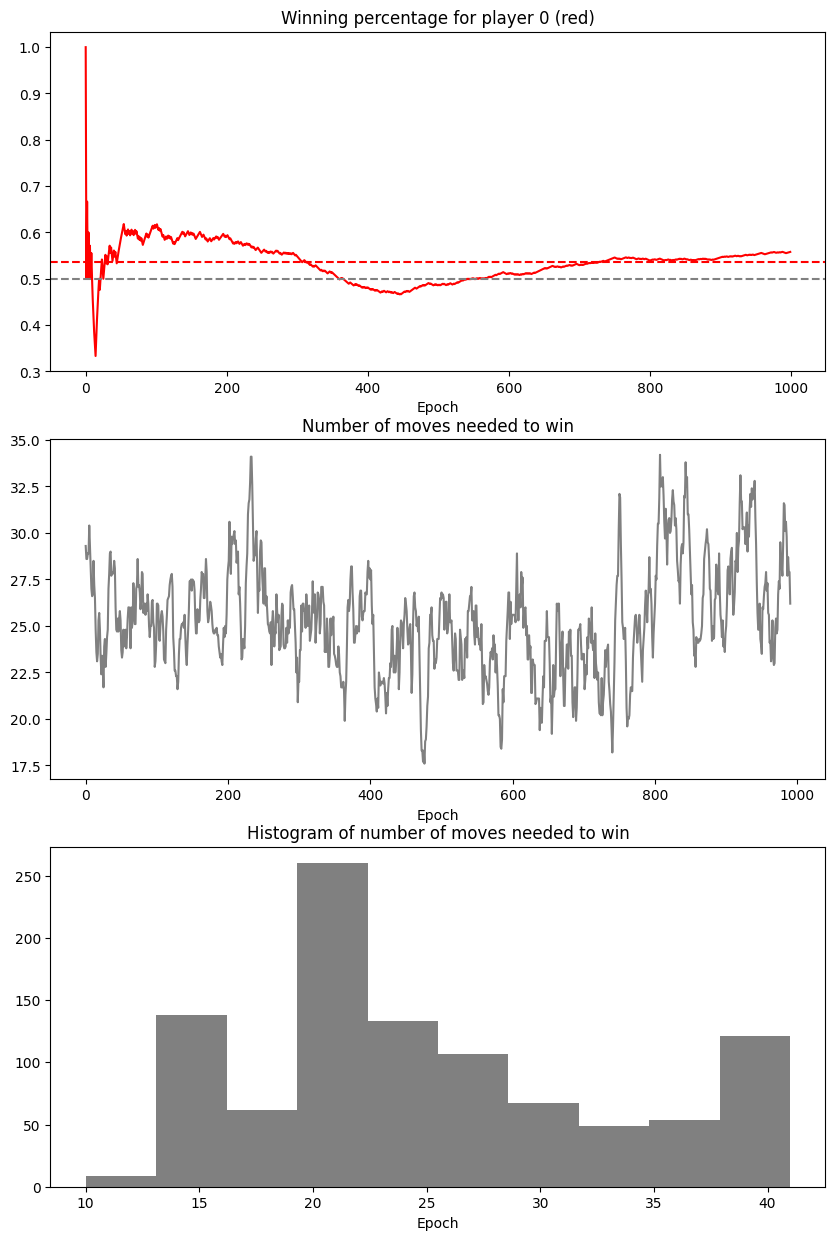

In [163]:
Q.plot_training_stats()
plt.show()

# Look at a game

In [118]:
Q.play()

In [11]:
player = Player(get_action=lambda state: Q.get_action(state))